In [1]:
%pylab inline
%config InlineBackend.figure_format='png'
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
data_dir ='/home/jonesdc/jupyter/prospect/prospect_data/'

Populating the interactive namespace from numpy and matplotlib


# Get the Huber U235 Spectrum

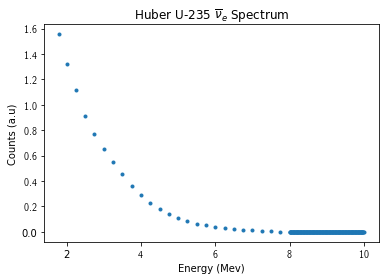

In [2]:
enhub, u235, u238, pu239, pu241 = np.loadtxt(f'{data_dir}/Huber.dat', unpack=True)
#print(en)
plt.plot(enhub,u235,'.')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.title('Huber U-235 $\\overline{\\nu}_{e}$ Spectrum')
plt.ylabel('Counts (a.u)')
plt.xlabel('Energy (Mev)')
plt.show()


# Get the Vogel-Beacom IBD Cross Section

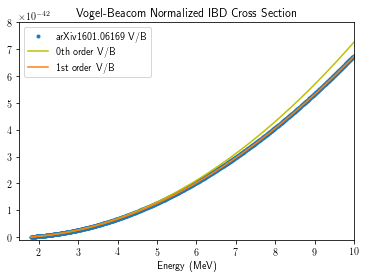

In [3]:
from scipy.integrate import quad

def f2():
    mu_p = 2.7928473508-1.0
    mu_n = -1.91304272
    return mu_p-mu_n

def g():
    return 1.2723

def sig0():
    hbarc = 1.97326971e-11
    Gf = 1.1663787e-11*hbarc
    costhetaC = 0.97425
    pi = 3.1415926
    DeltaR = 0.024
    return (Gf*costhetaC)**(2)*(1+DeltaR)/pi

def diffcx0(x,enu):
    Delta = 1.29333236 #mass difference between proton and neutron
    me = 0.5109989461
    mp = 938.272
    E0 = 0 if enu < Delta+me+1e-8 else enu-Delta
    p0 = 0 if E0 < me  else (E0**(2)-me**(2))**(0.5)
    v0 = 0 if E0 == 0  else p0/E0;
    #print("p0 ",p0," enu ",enu, " E0 ",E0)
    return sig0()/2.0*((1+3*g()**2)+(1-g()**2)*v0*x)*E0*p0

def diffcx1(x, enu):
    if(enu <= 1.804):
        return 0
    Delta = 1.29333236 #mass difference between proton and neutron
    me = 0.5109989461
    mp = 938.272
    M = mp+Delta/2
    E0 = 0 if enu < Delta+me else enu-Delta
    p0 = 0 if E0 < me else (E0**(2)-me**(2))**(0.5)
    v0 = 0 if E0 == 0 else p0/E0;
    E1 = E0*(1-enu/M*(1-v0*x))-(Delta**2-me**2)/(2*M)
    p1 = 0 if E1 < me else (E1**2-me**2)**(0.5)
    #print(p0," ",p1)
    v1 = 0 if E1==0 else p1/E1
    gam = 2*(1+f2())*g()*((2*E0+Delta)*(1-v0*x)-me**2/E0)
    gam += (1+g()**2)*(Delta*(1+v0*x)+me**2/E0)
    gam += (1+3*(g()**2))*((E0+Delta)*(1-x/v0)-Delta)
    gam += (1-g()**2)*((E0+Delta)*(1-x/v0)-Delta)*v0*x
    return sig0()/2*( ( (1+3*g()**2) + (1-g()**2)*v1*x )*E1*p1 - gam/M*E0*p0 )
    
def IBD_CX(enu, order):#Follows PhysRevD 053003 vol. 60
    cx0 = quad(diffcx0,-1,1,args=(enu))[0]
    cx1 = quad(diffcx1,-1,1,args=(enu))[0]
    #print('cx0 ',cx0,' cx1 ',cx1,' cxtot ', cx0+cx1)
    return cx0 if order==0 else cx1

#print(IBD_CX(4))
en2, cx = np.loadtxt(f'{data_dir}/IBD_CX_VogelBeacom.txt', unpack=True)#Supplemental material arxiv.org/abs/1601.06169
cx *= 1e-38
plt.plot(en2, cx,'.',label='arXiv1601.06169 V/B')

plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.title("Vogel-Beacom Normalized IBD Cross Section")
plt.xlabel("Energy (MeV)")
plt.xlim(1.5,10)
plt.ylim(-1e-43,0.8e-41)
cx2 = []
cx3 = []
for i in en2:
    enu = i
    ibdcx = IBD_CX(i,0)
    cx2.append(ibdcx)
    #print(i," ",ibdcx)
    ibdcx = IBD_CX(i,1)
    cx3.append(ibdcx)
plt.plot(en2,cx2,'y-',label='0th order V/B')
plt.plot(en2,cx3, label='1st order V/B')
plt.legend()
plt.show()



# Now find the IBD spectrum

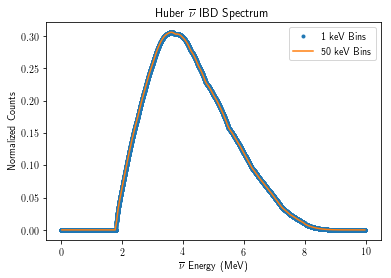

In [4]:
huber_spect1 = []
en1keV = np.linspace(0,10,10000,endpoint=False)
en50keV = np.linspace(0,10,200,endpoint=False)
en50keV += 0.025
i=0
np.append(enhub,10)
np.append(u235,2.2316010e-9)
#print(u235)
for eng in en1keV:
    spect = np.interp(eng,enhub,u235, right=0, left=0)*IBD_CX(eng,1) if eng >1.80 else 0
    #print(eng," ",spect)
    huber_spect1.append(spect)

huber_spect1_norm = huber_spect1/np.trapz(huber_spect1, en1keV)

plt.plot(en1keV,huber_spect1_norm,'.',label='1 keV Bins')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.title("Huber $\\overline{\\nu}$ IBD Spectrum")
plt.xlabel("$\\overline{\\nu}$ Energy (MeV)")
plt.ylabel("Normalized Counts")
huber_spect50 = np.mean(np.asarray(huber_spect1_norm).reshape(200,-1), axis=1)
plt.plot(en50keV, huber_spect50,'-', label='50 keV Bins')
plt.legend()
plt.show()

## Load the PROSPECT detector response matrix

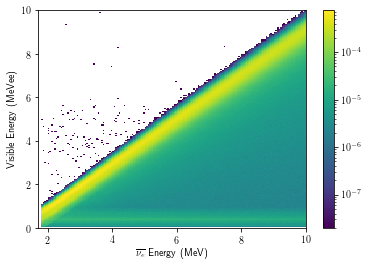

In [5]:
resp_mat = np.loadtxt(f'{data_dir}/ResponseMatrix.txt',delimiter=',')
plt.imshow(resp_mat.T,norm=LogNorm(),extent=(0,10,0,10),aspect='auto',origin='lower')
plt.colorbar()
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.ylabel('Visible Energy (MeVee)')
plt.xlabel('$\\overline{\\nu_{e}}$ Energy (MeV)')
plt.xlim(1.7)
plt.show()

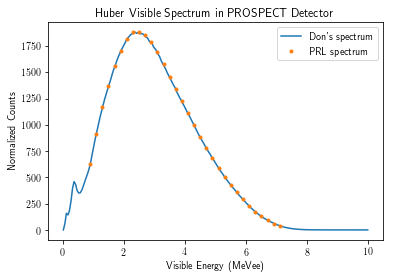

In [6]:
huber_spect_psp = np.matmul(huber_spect50, resp_mat)
#print(huber_spect)
en, hfir, huber, al, he, noneq = np.loadtxt(f'{data_dir}/HFIRSpectrumPrediction.txt', delimiter=',',unpack=True)
huber_spect_psp /= np.amax(huber_spect_psp)/np.amax(huber)
plt.plot(en50keV,huber_spect_psp,'-',label='Don\'s spectrum')
plt.xlabel("Visible Energy (MeVee)")
plt.ylabel("Normalized Counts")
plt.title("Huber Visible Spectrum in PROSPECT Detector")
#plt.show()

plt.plot(en, huber,'.',label='PRL spectrum')
plt.legend()
plt.show()